### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pycs.astro.wl.mass_mapping import *
from pycs.sparsity.sparse2d.starlet import *
from pycs.misc.cosmostat_init import *
from pycs.astro.wl.hos_peaks_l1 import *

In [2]:
import sp_peaks
from sp_peaks import slics
from sp_peaks import mapping
from sp_peaks import summary_statistics
from sp_peaks import plotting

### Bookkeeping

In [3]:
# Define root directory where the simulation files are located
root_directory = "/n17data/tersenov/SLICS/Cosmo_DES"

# Directories to exclude
exclude_dirs = ["SLICS_HR", "fid_a", "fid_f"]

# Open the master text file in write mode
master_file_path = ".././input/master_file.txt"
with open(master_file_path, "w") as master_file:
    # Iterate over the files and subdirectories in the root directory
    for root, dirs, files in os.walk(root_directory):
        # Exclude the specified directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file_name in files:
            # Write the file path to the master file
            file_path = os.path.join(root, file_name)
            master_file.write(file_path + "\n")

In [3]:
# Read the file paths from master_file.txt
filename = ".././input/master_file.txt"
with open(filename, 'r') as file:
    file_paths = file.readlines()
    file_paths = [path.strip() for path in file_paths]

filename_data = slics.parse_SLICS_filenames(file_paths)

In [4]:
# Path to the .dat file
# dat_file_path = "/home/tersenov/shear-pipe-peaks/example/CosmoTable.dat" # for CANDIDE
dat_file_path = "/Users/atersenov/Software/shear-pipe-peaks/example/CosmoTable.dat" # for local machine

# Read the cosmological parameters from the .dat file
cosmo_params = slics.read_SLICS_cosmo_params(dat_file_path)

mapped_params = slics.map_cosmo_params_to_data(filename_data, dat_file_path)

### Read catalog and generate density map and noise map

Constants and parameters

In [29]:
# Constants and Parameters
# CATALOG_FILE = "/n17data/tersenov/SLICS/Cosmo_DES/16_a/LOS4/DES_MocksCat_16_a_4_Bin3_LOS4_R4.dat" # for CANDIDE
CATALOG_FILE = "/Users/atersenov/Software/test_cosmostat/data/DES_MocksCat_16_a_4_Bin3_LOS4_R4.dat" # for local machine
N_GAL = 7 
SIZE_X_DEG = 10.
SIZE_Y_DEG = 10.
PIX_ARCMIN = 1.
SHAPE_NOISE = 0.44
NSCALES = 5

# Histogram parameters
MIN_SNR = -2
MAX_SNR = 6
NBINS=31
NBINS_L1 = 40


# NBINS = 40 
# KAPPA_SNR = np.linspace(-2, 6, 31)

Load catalog

In [30]:
# Load the catalog data 
catalog_data = slics.read_catalogue_pd(CATALOG_FILE)

ra = catalog_data['RA']
dec = catalog_data['Dec']
g1_sim = catalog_data['gamma1_sim']
g2_sim = catalog_data['gamma2_sim']
kappa_sim = catalog_data['kappa_sim']

Project (ra,dec) -> (x,y) 

In [31]:
# Project (ra,dec) -> (x,y)
x, y = radec2xy(np.mean(ra), np.mean(dec), ra, dec)

In [32]:
# Calculate the number of pixels in the x and y directions
Nx, Ny = int(SIZE_X_DEG / PIX_ARCMIN * 60), int(SIZE_Y_DEG / PIX_ARCMIN * 60)

Galaxies per pixel map

In [33]:
# create the galaxy number density map
galmap = bin2d(x, y, npix=(Nx,Ny))

Mask

In [34]:
# get the mask from the galaxy density map (the mask is 1 where there are galaxies and 0 where there are no galaxies)
mask = (galmap > 0).astype(int)

Noise map

In [35]:
sigma_noise = np.zeros_like(galmap)
sigma_noise[mask != 0] = SHAPE_NOISE / np.sqrt(2 * galmap[mask != 0])
sigma_noise[mask == 0] = np.max(sigma_noise[mask != 0]) # set the noise to the maximum value in the map where there are galaxies

In [36]:
noise_map_CFIS_z05 = sigma_noise * np.random.randn(sigma_noise.shape[0], sigma_noise.shape[1]) # generate noise map

## Mass mapping

Bin shear

In [37]:
# bin the shear field into a 2D map
e1map, e2map = bin2d(x, y, npix=(Nx, Ny), v=(g1_sim, g2_sim)) 

Initialize `shear_data` and `massmap2d` classes

In [38]:
# Shear data class initialization
d = shear_data()
d.g1 = e1map
d.g2 = -e2map
(nx,ny) = e1map.shape
d.mask = mask

In [39]:
# Shear noise covariance matrix
Ncov = np.zeros((nx,ny))
Ncov[mask > 0] = 2. * sigma_noise[mask > 0]**2
Ncov[mask == 0] = 1e9 # set the noise to the maximum value in the map where there are galaxies

d.Ncov = Ncov
d.nx = nx
d.ny = ny  

In [40]:
# Mass mapping class initialization
M = massmap2d(name='mass')
M.init_massmap(d.nx,d.ny)
M.DEF_niter = 50
Inpaint = True
M.niter_debias = 30
M.Verbose = False 

Mass maps

In [41]:
# KS
ks =  M.gamma_to_cf_kappa(e1map,-e2map) 
ks = ks.real

In [42]:
# KS + Inpainting
ksi =  M.iks(d.g1, d.g2, mask) 
ksi = ksi.real

## Statistics

Add noise to mass maps

In [43]:
ks_noisy = ks + noise_map_CFIS_z05
ksi_noisy = ksi + noise_map_CFIS_z05

Initialize `starlet2d` and `HOS_starlet_l1_norm_peaks` classes

In [44]:
WT = starlet2d(gen2=False,l2norm=False, verb=False)
WT.init_starlet(nx, ny, nscale=NSCALES)
H = HOS_starlet_l1norm_peaks(WT)

In [45]:
H.set_bins(Min=MIN_SNR, Max=MAX_SNR, nbins=NBINS)
H.set_data(ks_noisy, SigmaMap=sigma_noise, Mask=mask)
H.get_mono_scale_peaks(ks_noisy, sigma_noise, mask=mask)
H.get_wtpeaks(Mask=mask)
pc = H.Peaks_Count
H.get_wtl1(NBINS_L1*2, Mask=mask)

Scale  1 : Min =  -21.56278607811683 , Max =  25.573993418106035
Scale  2 : Min =  -10.568691528151694 , Max =  11.219488234319215
Scale  3 : Min =  -6.99490132233732 , Max =  7.681753149922091
Scale  4 : Min =  -6.7779094870346555 , Max =  6.85541712723588
Scale  5 : Min =  -8.143986746315264 , Max =  10.475693378978113


In [46]:
# TEST
H.set_data(ks_noisy, SigmaMap=sigma_noise, Mask=mask)
H.get_wtl1(NBINS_L1*2, Mask=mask)

In [47]:
#check the shape of the l1bins
print(H.l1bins.shape)
print(H.l1norm.shape)

(5, 80)
(5, 80)


## Plotting

Mass map

/Users/atersenov/miniconda3/envs/pysap/lib/python3.9/site-packages/pycs/misc/cosmostat_init.py:345: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


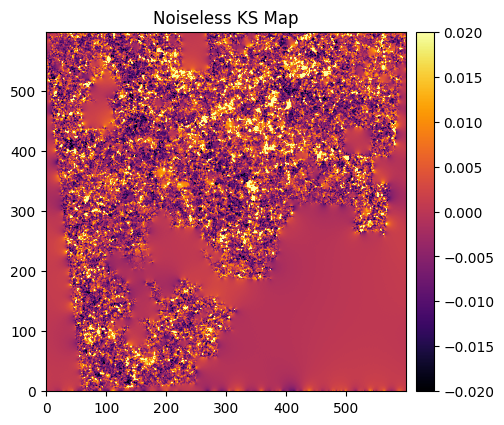

In [48]:
tvilut(ks, title='Noiseless KS Map', lut='inferno', vmin=-0.02, vmax=0.02, fs=5)

Noisy mass map

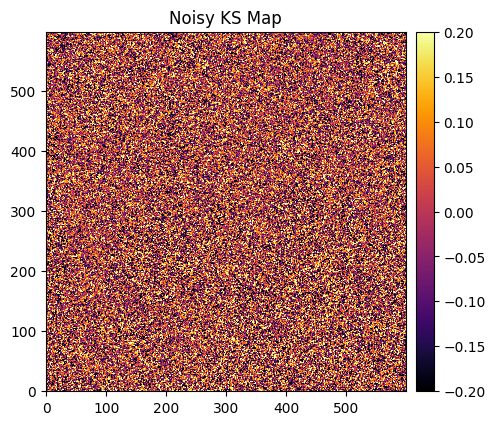

In [49]:
tvilut(ks_noisy, title='Noisy KS Map', lut='inferno', vmin=-0.2, vmax=0.2, fs=5)

Mono-scale peaks

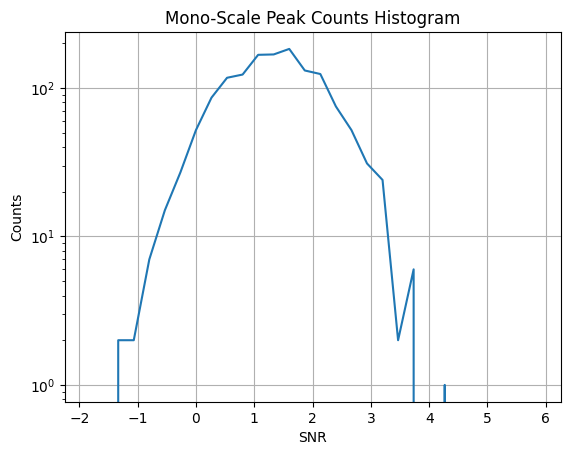

In [50]:
H.plot_mono_peaks_histogram()

Multiscale peaks

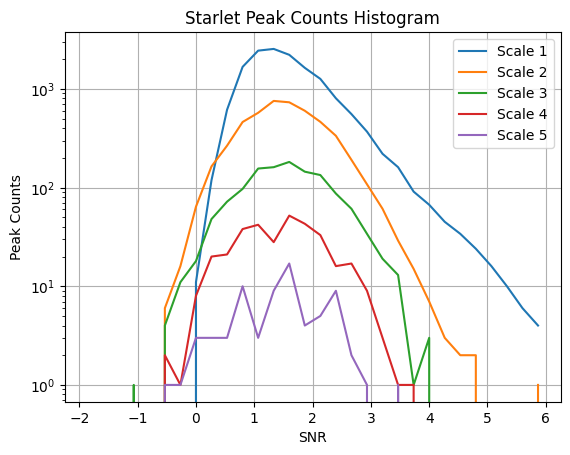

In [51]:
H.plot_peaks_histo(log_scale=True)

$\ell_1$ norm

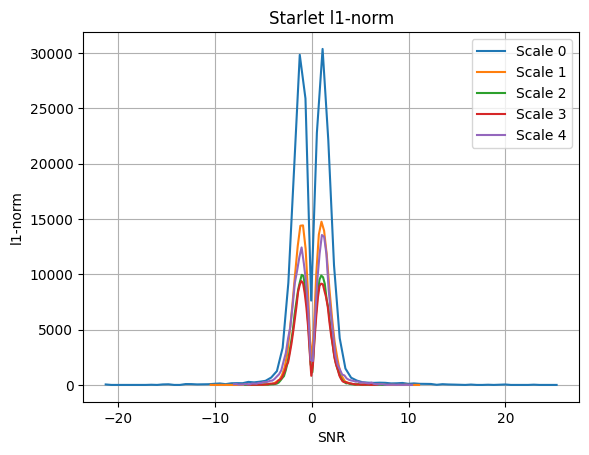

In [52]:
H.plot_l1norm()